In [1]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pickle
from importlib import reload
import numpy as np
from hmmlearn.hmm import GaussianHMM

In [3]:
hmm_data = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/synthetic_tests/unstructured_hmm_data.pkl', 'rb'))

In [4]:
curr_train = hmm_data['train_data'][0]

multiple sequences given


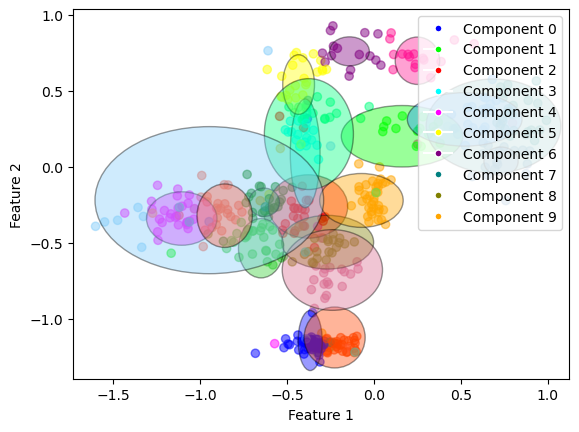

In [5]:
import final.models.hdphmm.bhmm.bhmm as bhmm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
reload(bhmm)
train = curr_train
my_bhmm = bhmm.BayesianHMM(X=train, K=20, iterations=5, alpha0=0.5, kappa0=10,
                           outer_its=1000, verbose=True, convergence_check=200)
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(train[0], my_bhmm.Z, my_bhmm.K, my_bhmm.mu, my_bhmm.sigma, feature_a=0, feature_b=1)

In [7]:
hmm_from_trace = my_bhmm.fit()
plot_hmm.plot_hmm_data(curr_train[0], hmm_from_trace.predict(curr_train[0]), hmm_from_trace.n_components, hmm_from_trace.means_, hmm_from_trace.covars_, feature_a=0, feature_b=1)

starting gibbs sampling
outer it:  0
removing empty component(s)
removing empty component(s)
it:  10 score:  0 n-components:  13
removing empty component(s)
it:  20 score:  0 n-components:  12
removing empty component(s)
it:  30 score:  0 n-components:  11
it:  40 score:  0 n-components:  11
it:  50 score:  55.83192024922469 n-components:  11
it:  60 score:  46.20278061447055 n-components:  11
outer it:  1
it:  70 score:  120.76534171584964 n-components:  11
removing empty component(s)
it:  80 score:  0 n-components:  10
it:  90 score:  0 n-components:  10
it:  100 score:  75.3908802811525 n-components:  10
it:  110 score:  76.52020421722646 n-components:  10
it:  120 score:  65.83648384420293 n-components:  10
outer it:  2
it:  130 score:  124.1258486351549 n-components:  10
it:  140 score:  87.54221169457102 n-components:  10
removing empty component(s)
it:  150 score:  0 n-components:  9
it:  160 score:  0 n-components:  9
it:  170 score:  40.70683778906912 n-components:  9
it:  180

In [5]:
import time
# reload(bhmm)
curr_test = hmm_data['test_data']

ns = np.arange(2,21,1)
n_inits = np.arange(0,4,1)

In [9]:

start_outer = time.time()
results_gibbs_finite = {}
results_per_component = {}
for n in ns:

    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    models_gibbs = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits:
            total_inits += 1

            my_bhmm = bhmm.BayesianHMM(X=curr_train, K=n, iterations=50, alpha0=0.5, kappa0=10, outer_its=1000, verbose=False, convergence_check=200)
            curr_hmm = my_bhmm.fit()
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            models_gibbs.append(my_bhmm)

            # final components from A matrix
            final_components.append(curr_hmm.n_components)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'models_gibbs': models_gibbs,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'final_components': final_components,
        'final_components_mean': np.mean(final_components),
        'final_components_max':  models[best_model].n_components
    }
    print('n comps: ', np.mean(final_components), 'test_val: ', results_per_component[n]['test'])

end_outer = time.time()
results_gibbs_finite['total_time'] = end_outer - start_outer
results_gibbs_finite['components'] = results_per_component
results_gibbs_finite['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_gibbs_finite['component_list'] = ns


calculating for n:  2


KeyboardInterrupt: 

In [29]:
output = open('results_gibbs_finite' + ".pkl", "wb")
pickle.dump(results_gibbs_finite, output)
output.close()

In [10]:
results_gibbs_finite = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing/results_gibbs_finite.pkl', 'rb'))

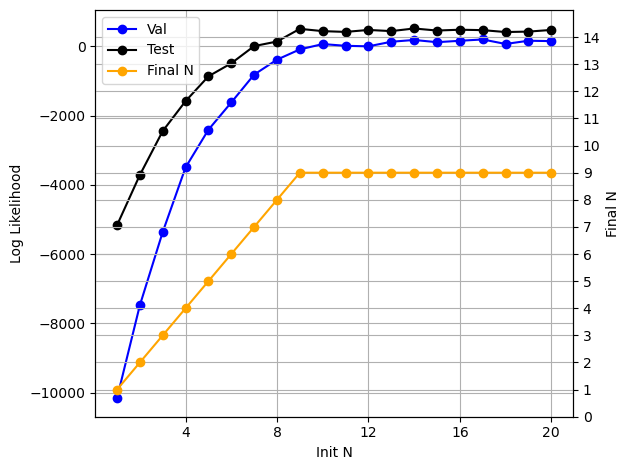

In [18]:
import matplotlib.pyplot as plt

components_results = results_gibbs_finite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_max'] for some_key in components_results]

fig, ax = plt.subplots()

ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
ax2.set_ylim(0,15)
ax2.set_yticks(np.arange(0,15,1))

ax.set_xticks(np.arange(4,21,4))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
# ax3.set_ylabel("Elbo")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)


ax.legend(handles=ax.lines + ax2.lines) # + ax3.lines)
# ax.set_title("HMM Gibbs Finite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax.grid(True)  # Enable grid on primary axis
ax2.grid(True)  # Enable grid on secondary axis
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()

plt.show()


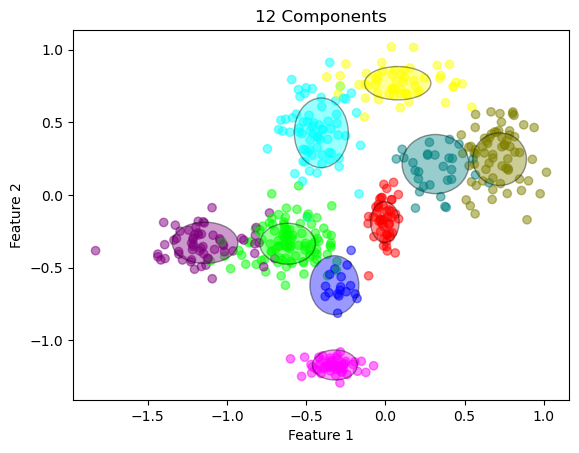

In [32]:
# temp = np.argmax([results_em['components'][some_key]['test'] for some_key in results_em['components']])
hmm_temp = results_gibbs_finite['components'][12]['models'][0]
plot_hmm.plot_hmm_data(curr_test[1], hmm_temp.predict(curr_test[1]), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='12 Components')

In [18]:
print('max finite gibbs test value: ', np.max([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']]), (np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])), results_gibbs_finite['total_time'])

max finite gibbs test value:  543.039454698845 16 946.5600550174713


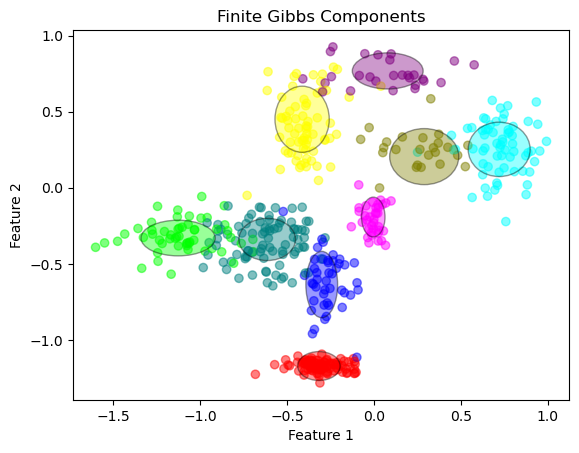

In [18]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

data_temp = hmm_data['train_data'][0][0]

temp = np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])
hmm_temp = results_gibbs_finite['components'][10 + 1]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='Finite Gibbs Components')

In [10]:
# not working yet :/

import final.models.hdphmm.hdphmmda.hdp_hmm_da as hdp_hmm_da
reload(hdp_hmm_da)

# my_bhmm = bhmm.BayesianHMM(X=train, K=20, iterations=5, alpha0=0.5, kappa0=10,
#                            outer_its=1000, verbose=True, convergence_check=200)
# import final.models.hdphmm.helpers.plot_hmm as plot_hmm
# reload(plot_hmm)
# plot_hmm.plot_hmm_data(train[0], my_bhmm.Z, my_bhmm.K, my_bhmm.mu, my_bhmm.sigma, feature_a=0, feature_b=1)

my_hdphmm_da = hdp_hmm_da.InfiniteDirectSamplerHMM(hmm_data['train_data'][0], K=20, outer_its=10, iterations=20,convergence_check=200, verbose=True)
my_hdphmm_da_fitted_hmm = my_hdphmm_da.fit()

multiple sequences given


In [24]:
output = open('my_hdphmm_da_fitted_hmm' + ".pkl", "wb")
pickle.dump(my_hdphmm_da_fitted_hmm, output)
output.close()

In [6]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmmwl
reload(hdphmmwl)

my_hdphmm_wl = hdphmmwl.HDPHMMWL(hmm_data['train_data'][0], K=20, outer_its=100, iterations=50, convergence_check=200, max_it=1000)

multiple sequences given


In [ ]:
curr_hmm = my_hdphmm_wl.fit_multiple(verbose=False)
curr_hmm.score(np.concatenate(curr_test))
plot_hmm.plot_hmm_data(data_temp, curr_hmm.predict(data_temp), curr_hmm.n_components, curr_hmm.means_, curr_hmm.covars_, feature_a=0, feature_b=1, legend=False, title='Infinite Gibbs Components')

In [7]:
import time

# ns = np.arange(2,21,1)
# n_inits = np.arange(0,2,1)

In [8]:

start_outer = time.time()
results_gibbs_infinite = {}
results_per_component = {}
for n in ns:
    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    models_gibbs = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits:
            total_inits += 1

            my_hdphmm_wl = hdphmmwl.HDPHMMWL(curr_train, K=n, outer_its=100, iterations=50,
                                             convergence_check=200, max_it=1000)
            curr_hmm = my_hdphmm_wl.fit_multiple()
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            models_gibbs.append(my_hdphmm_wl)

            # final components from A matrix
            final_components.append(curr_hmm.n_components)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'models_gibbs': models_gibbs,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'final_components': final_components,
        'final_components_mean': np.mean(final_components),
        'final_components_max':  models[best_model].n_components
    }
    print('n comps: ', np.mean(final_components), 'test_val: ', results_per_component[n]['test'])

end_outer = time.time()
results_gibbs_infinite['total_time'] = end_outer - start_outer
results_gibbs_infinite['components'] = results_per_component
results_gibbs_infinite['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_gibbs_infinite['component_list'] = ns


calculating for n:  2
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.7623870372772217
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.687563896179199
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.2528629302978516
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.1518757343292236
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.1655972003936768
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.1084139347076416
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.1352341175079346
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.113183975219

In [20]:
output = open('results_gibbs_infinite' + ".pkl", "wb")
pickle.dump(results_gibbs_infinite, output)
output.close()

In [23]:
results_gibbs_infinite = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing/results_gibbs_infinite.pkl', 'rb'))

In [24]:
import matplotlib.pyplot as plt

components_results = results_gibbs_infinite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = np.array([components_results[some_key]['final_components_max'] for some_key in components_results])
# argmax =  np.array([np.argmax(components_results[some_key]['lls']) for some_key in components_results])
# final_components = np.array([components_results[some_key]['final_components'] for some_key in components_results])
# argmax_components = [final_components[i, argmax[i]] for i in range(len(argmax))]

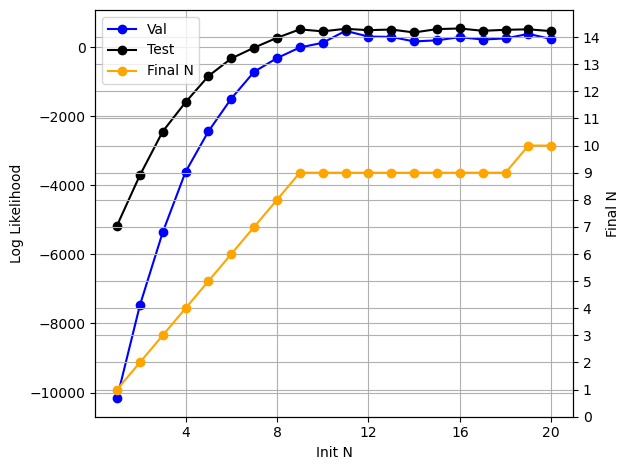

In [25]:
fig, ax = plt.subplots()

ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
ax2.set_ylim(0,15)
ax2.set_yticks(np.arange(0,15,1))

ax.set_xticks(np.arange(4,21,4))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
# ax3.set_ylabel("Elbo")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines) # + ax3.lines)
# ax.set_title("HMM Gibbs Infinite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
ax.grid(True)  # Enable grid on primary axis
ax2.grid(True)  # Enable grid on secondary axis
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


In [29]:
print('max finite gibbs test value: ', np.max([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']]), (np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])), results_gibbs_finite['total_time'])


max finite gibbs test value:  520.4000022473684 13 942.6713109016418


In [28]:
components_results = results_gibbs_finite['components']
some_std_avg = np.mean([np.std(components_results[some_key]['lls']) for some_key in components_results], axis=0)

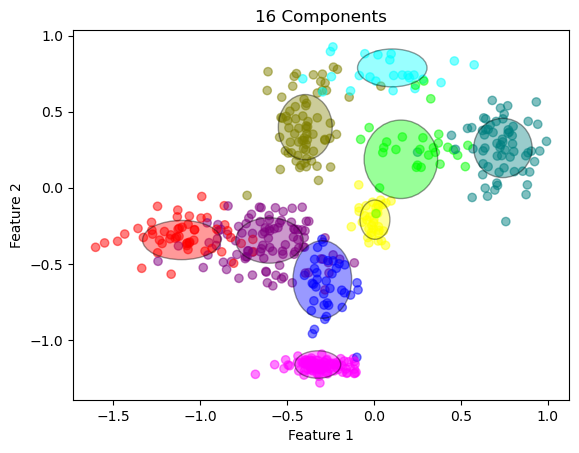

In [19]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

data_temp = hmm_data['train_data'][0][0]

temp = np.argmax([results_gibbs_infinite['components'][some_key]['test'] for some_key in results_gibbs_infinite['components']])
hmm_temp = results_gibbs_infinite['components'][15 + 2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='16 Components')